Fig. 4a, b

In [1]:
import sys
import os
import argparse
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.colors import BoundaryNorm, Normalize
from matplotlib.patches import Circle

from DATA.MetUM_variables import VARDIC
from config import *
from CP4.utils.make_colorbar import MidpointNormalize
from CP4.make_composites.SM_contrast.b1_make_var_field_anomaly_contrast import load_contrast_composite_mean_ano_field
from CP4.make_composites.SM_contrast.significance.b_compute_var_field_significance_contrast_merge import load_contrast_composite_significance_pvalues_merge
from CP4.plots.p_config import *

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [5]:
coords = [[(10., 18.), (-20., -10.)], [(10.,18.), (-14., -4.)], [(10.,18.), (-8., 2.)], [(10.,18.), (-2.,8.)], [(8.,16.), (8.,18.)]]

In [26]:
ds='CP4A'
res=4
var_ref='twb'
var='sh'
window=6
y0=1997
y1=2006
months=[5, 6, 7, 8, 9]
q_thresh=0.95
t_thresh=26.
min_hw_size=100.   # km2
max_hw_size=1000000.   # km2
sw=[4., 4.]
tw=[-72, 72]
n_days=3
meth='cc3d'
cnty=26
samtime=[15, 15]
pvalue=0.01  # km
length = 25
size = 'small'
size_length=25
flabel='a'

In [27]:
years = np.arange(y0, y1+1, 1)
years_ = str(y0) + '-' + str(y1)
months_ = "-".join([str(m) for m in months])

res_ = str(res) + 'km'

swlat = sw[0]
swlon = sw[1]
sw_ = str(swlat) + 'x' + str(swlon)

space_scale = str(min_hw_size) + '-' + str(max_hw_size)
space_scale_ = str(int(min_hw_size)) + '-' + str(int(max_hw_size))

tw_before = tw[0]
tw_after = tw[1]
assert tw_before <= tw_after, "Incorrect number of time steps"
tw_ = str(tw_before) + '_to_' + str(tw_after)

In [28]:
#~ Get data

pvalues = load_contrast_composite_significance_pvalues_merge(ds, res, var_ref, var, y0, y1, months, t_thresh, q_thresh, n_days, meth, cnty, window, sw, tw, samtime, min_hw_size, max_hw_size, size, size_length)

out_anos = []
out_anos_u = []
out_anos_v = []

for icoord, coord in enumerate(coords):
    lat_range = coord[0]
    lon_range = coord[1]

    ds_ano = load_contrast_composite_mean_ano_field(ds, res, var_ref, var, y0, y1, months, lat_range, lon_range, t_thresh, q_thresh, n_days, meth, cnty, window, sw, tw, samtime, min_hw_size, max_hw_size, size, size_length)

    ds_ano_u = load_contrast_composite_mean_ano_field(ds, res, var_ref, 'u10', y0, y1, months, lat_range, lon_range, t_thresh, q_thresh, n_days, meth, cnty, window, sw, tw, samtime, min_hw_size, max_hw_size, size, size_length)
    ds_ano_v = load_contrast_composite_mean_ano_field(ds, res, var_ref, 'v10', y0, y1, months, lat_range, lon_range, t_thresh, q_thresh, n_days, meth, cnty, window, sw, tw, samtime, min_hw_size, max_hw_size, size, size_length)

    print('\n{0}: N={1}'.format(coord, ds_ano.shape[0]))

    out_anos.append(ds_ano)
    out_anos_u.append(ds_ano_u)
    out_anos_v.append(ds_ano_v)

out_anos = xr.concat(out_anos, dim='n')
out_anos_u = xr.concat(out_anos_u, dim='n')
out_anos_v = xr.concat(out_anos_v, dim='n')

n_hhee = out_anos.shape[0]


[(10.0, 18.0), (-20.0, -10.0)]: N=18

[(10.0, 18.0), (-14.0, -4.0)]: N=24

[(10.0, 18.0), (-8.0, 2.0)]: N=24

[(10.0, 18.0), (-2.0, 8.0)]: N=30

[(8.0, 16.0), (8.0, 18.0)]: N=27


In [29]:
#~ Treat data

windstep = 4

var_hhee_ano_mean = np.nanmean(out_anos.values, axis=0) # mean across events
var_hhee_ano_med = np.nanmedian(out_anos.values, axis=0) # median across events
var_hhee_ano_mean_u = out_anos_u.mean(axis=0)  # np.nanmean(out_anos_u.values, axis=0) # mean across events
var_hhee_ano_med_u = np.nanmedian(out_anos_u.values, axis=0) # median across events
var_hhee_ano_mean_v = out_anos_v.mean(axis=0)  # np.nanmean(out_anos_v.values, axis=0) # mean across events
var_hhee_ano_med_v = np.nanmedian(out_anos_v.values, axis=0) # median across events

ano_speed_mean = np.sqrt(var_hhee_ano_mean_u**2 + var_hhee_ano_mean_v**2)

pvalues_ = pvalues.where(pvalues > pvalue, 0)  # location where significant -> 0
pvalues_.values[pvalues_ > pvalue] = 1

var_hhee_ano_mean_u_nosig = var_hhee_ano_mean_u.where(pvalues_ == 1)
var_hhee_ano_mean_u_sig = var_hhee_ano_mean_u.where(pvalues_ == 0)
var_hhee_ano_mean_v_nosig = var_hhee_ano_mean_v.where(pvalues_ == 1)
var_hhee_ano_mean_v_sig = var_hhee_ano_mean_v.where(pvalues_ == 0)

var_hhee_ano_mean_u_nosig = var_hhee_ano_mean_u_nosig.interp(x=var_hhee_ano_mean_u_nosig.x[::windstep], y=var_hhee_ano_mean_u_nosig.y[::windstep])
var_hhee_ano_mean_u_sig = var_hhee_ano_mean_u_sig.interp(x=var_hhee_ano_mean_u_sig.x[::windstep], y=var_hhee_ano_mean_u_sig.y[::windstep])
var_hhee_ano_mean_v_nosig = var_hhee_ano_mean_v_nosig.interp(x=var_hhee_ano_mean_v_nosig.x[::windstep], y=var_hhee_ano_mean_v_nosig.y[::windstep])
var_hhee_ano_mean_v_sig = var_hhee_ano_mean_v_sig.interp(x=var_hhee_ano_mean_v_sig.x[::windstep], y=var_hhee_ano_mean_v_sig.y[::windstep])

var_hhee_ano_2plot = var_hhee_ano_mean

varanomean = np.nanmean(var_hhee_ano_2plot)  # spatial mean
varanomed = np.nanmedian(var_hhee_ano_2plot)

xs = np.linspace(-var_hhee_ano_mean.shape[1]/2, var_hhee_ano_mean.shape[1]/2, var_hhee_ano_mean.shape[1]) # np.arange(0.5, pvalues.shape[0], 1)
ys = np.linspace(-var_hhee_ano_mean.shape[0]/2, var_hhee_ano_mean.shape[0]/2, var_hhee_ano_mean.shape[0]) # np.arange(0.5, pvalues.shape[1], 1)
xc = (xs[-1]-xs[0])/2+xs[0]
yc = (ys[-1]-ys[0])/2+ys[0]

xsm, ysm = np.meshgrid(xs, ys)

r = length / 4.4  # nb of grid points

distloc = ( ((xsm - xc) * (xsm - xc)) + ((ysm - yc) * (ysm - yc)) )**.5  # 2d-array of distance to center values
disc_mask = np.broadcast_to(distloc <= r, out_anos.shape)
circ_mask = ((r-r/15 <= distloc) & (distloc <= r+r/15))

xscirc = xsm[circ_mask]
yscirc = ysm[circ_mask]

vals_ano_disc = ma.masked_array(out_anos.values, ~disc_mask)
vals_ano_disc = ma.filled(vals_ano_disc, fill_value=np.nan)
vals_ano_disc_mean = np.nanmean(vals_ano_disc, axis=0) # mean across events
vals_ano_disc_mean = np.nanmean(vals_ano_disc_mean)  # spatial mean

/tmp/ipykernel_575/3462870560.py:48: RuntimeWarning: Mean of empty slice
  vals_ano_disc_mean = np.nanmean(vals_ano_disc, axis=0) # mean across events


[Text(0, -45.45454545454545, '-200'),
 Text(0, -34.090909090909086, '-150'),
 Text(0, -22.727272727272727, '-100'),
 Text(0, -11.363636363636363, '-50'),
 Text(0, 0.0, '0'),
 Text(0, 11.363636363636363, '50'),
 Text(0, 22.727272727272727, '100'),
 Text(0, 34.090909090909086, '150'),
 Text(0, 45.45454545454545, '200')]

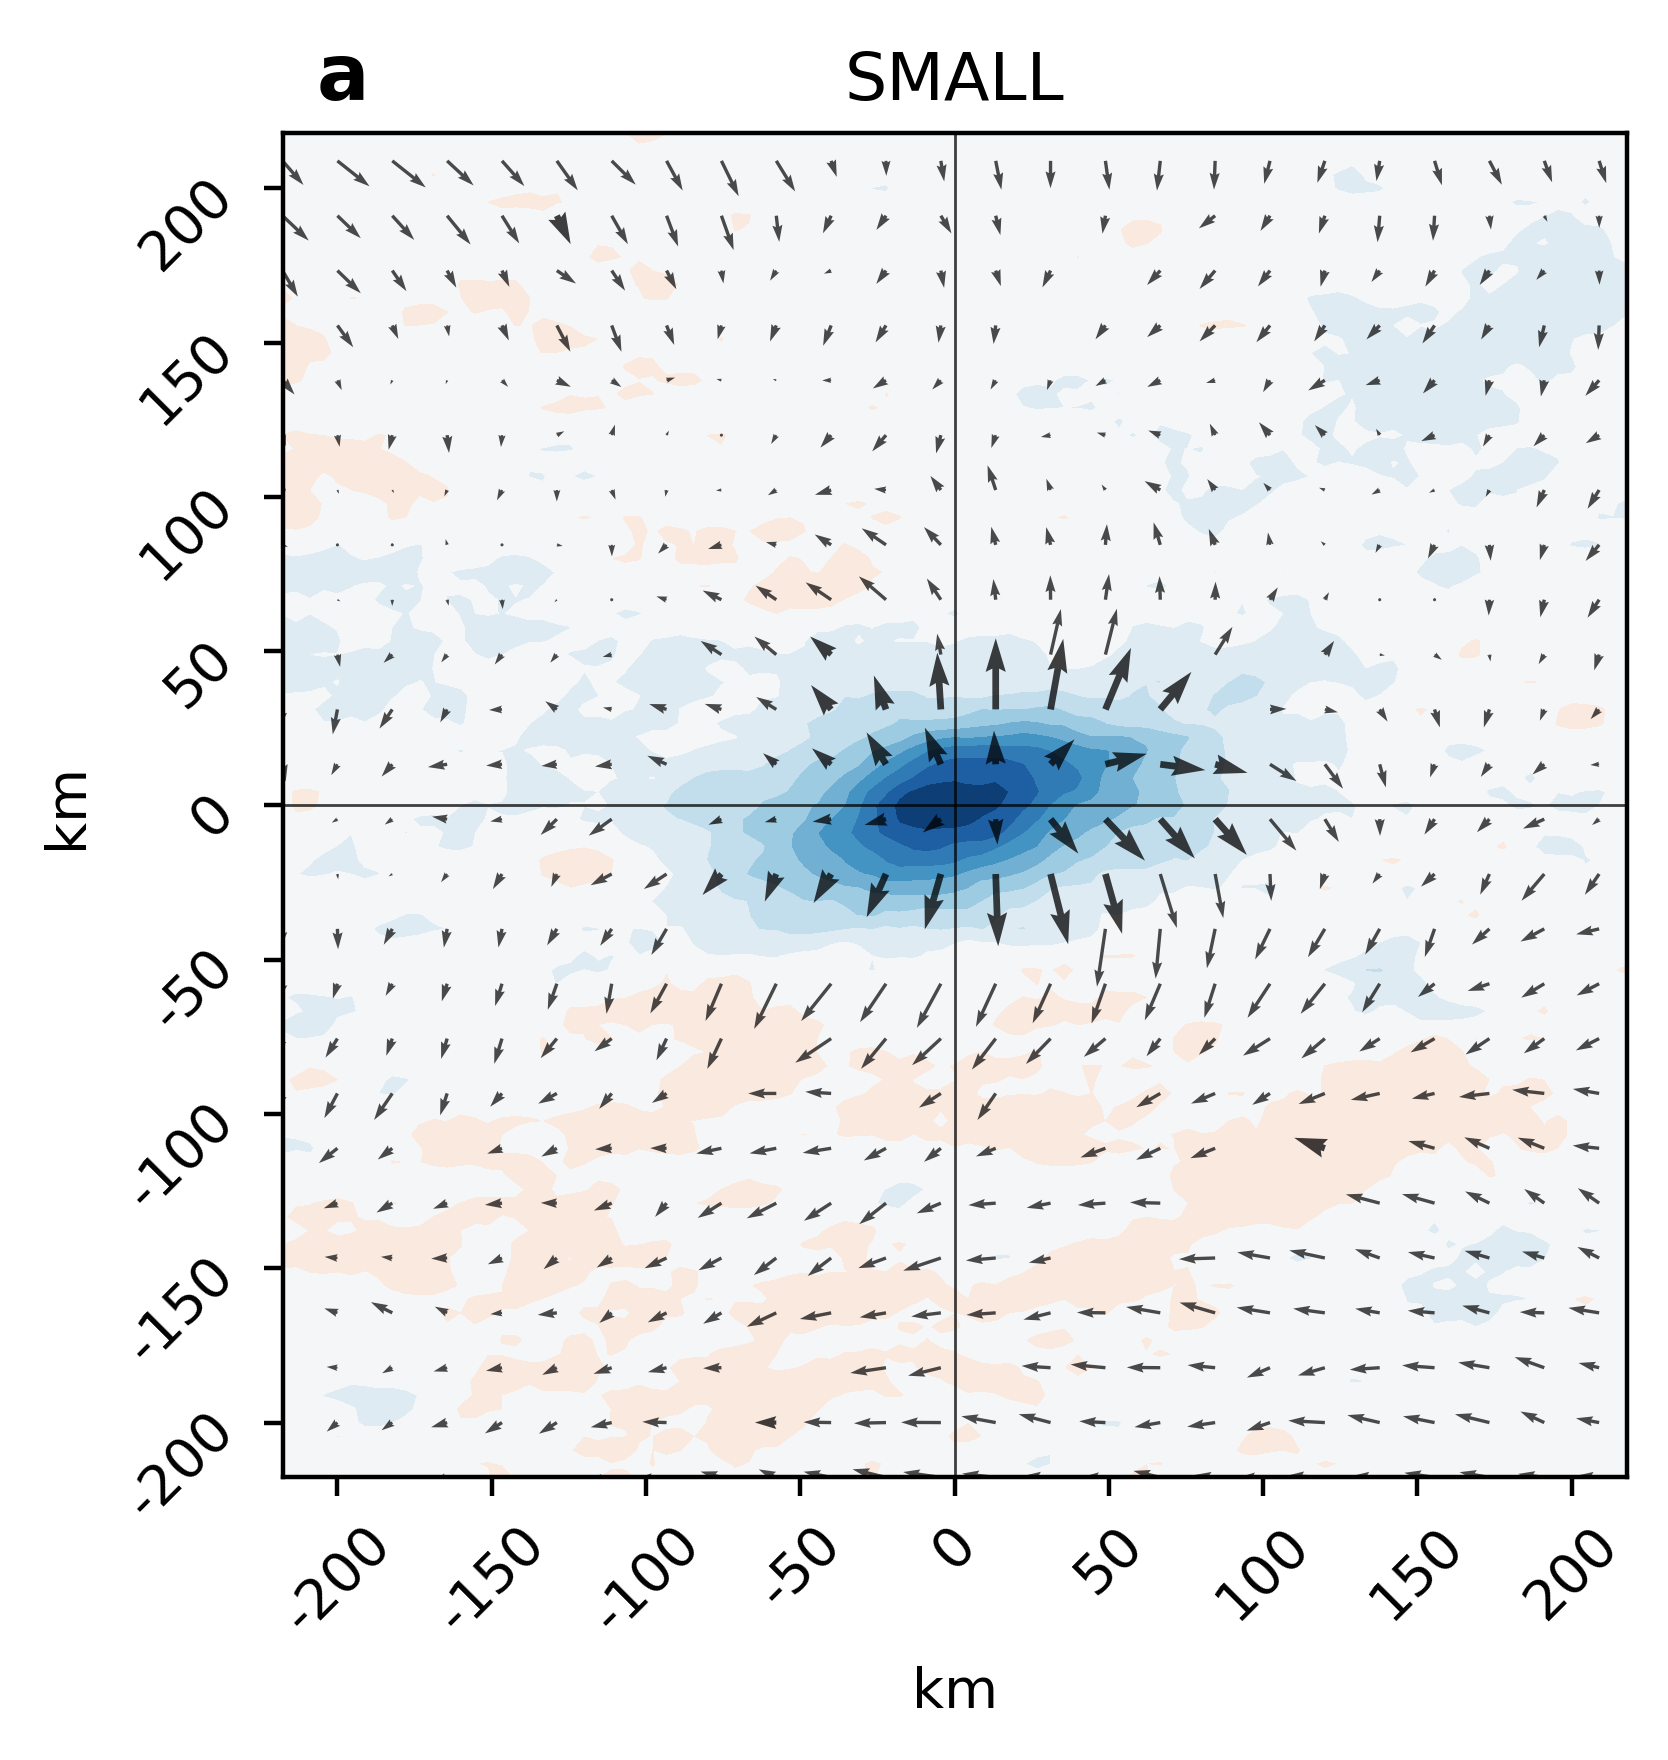

In [30]:
#~ Plot

lprop = {'small': ['-', 'b'], 'large': ['--', 'g']}

circle_ano = Circle((xs[int(len(xs)/2)], ys[int(len(ys)/2)]), r, facecolor='none', edgecolor=lprop[size][1], linewidth=1, linestyle=lprop[size][0], alpha=0.95)

if var == 'q2':
    rounder = 5
else:
	rounder = 2

xtlbs = np.arange(-200, 200+50, 50)
xtcks = xtlbs / 4.4
ytlbs = np.arange(-200, 200+50, 50)
ytcks = ytlbs / 4.4

anomin = anolims_SM_contrast[var][0]
anomax = anolims_SM_contrast[var][1]

cmap_ano = cmaps['ano']
cmap = plt.get_cmap(cmap_ano)
bounds = np.linspace(anomin, anomax, 11)
norm = MidpointNormalize(vmin=anomin, vmax=anomax, midpoint=0)  # vmin=anomin, vmax=vmax

varstepano = 4
anoscale = 0.2
arrow_length_ano = 1

fig_ano, ax_ano = plt.subplots(ncols=1, dpi=400)

plt.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)

ax_ano.contourf(xs, ys, var_hhee_ano_2plot, levels=bounds, norm=norm, cmap=cmap) # vmin=-anolim, vmax=anolim, cmap=cmap_ano)

p_ano_uv_nosig = ax_ano.quiver(xs[::windstep], ys[::windstep], var_hhee_ano_mean_u_nosig, var_hhee_ano_mean_v_nosig, color='k', width=0.0025, alpha=0.7, angles='xy', scale_units='xy', scale=anoscale)
p_ano_uv_sig = ax_ano.quiver(xs[::windstep], ys[::windstep], var_hhee_ano_mean_u_sig, var_hhee_ano_mean_v_sig, color='k', width=0.005, alpha=0.75, angles='xy', scale_units='xy', scale=anoscale)

ax_ano.text(0.025, 1.025, flabel, weight="bold", fontsize=14, transform=ax_ano.transAxes)

ax_ano.axhline(yc, 0, 1, color='k', alpha=0.75, lw=0.5)
ax_ano.axvline(xc, 0, 1, color='k', alpha=0.75, lw=0.5)

ax_ano.set_title('%s'%size.upper())
ax_ano.set_aspect('equal')
ax_ano.set_xlabel('km')
ax_ano.set_ylabel('km')
ax_ano.set_xticks(xtcks)
ax_ano.set_xticklabels(xtlbs, rotation=45)
ax_ano.set_yticks(ytcks)
ax_ano.set_yticklabels(ytlbs, rotation=45)